## Data Analysis

### Data We Have

We have the following data:

 * `data/statements/contest_[en/ro].json` - the statements of the problems in the contest.
 * `data/solutions/solutions_[en/ro]_round_[1/2/3].json` - the solutions of the problems in the contest. We have 3 rounds for accounting for variations in the LLMs' answers.

TODO:
 * Take care of precision issues (maybe?).
 * Ro vs en statistics.
 * Probably relax the &lt;PYTHON CODE> tag, as models fail to insert it.
 * For MateInfoUB: Add redundant information?

### Loading the Data

In [1]:
import matplotlib.pyplot as plt
import duckdb
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from IPython.core.magic import register_cell_magic

import internal_types
import compare_answers

def sql(*args):
    """
    Helper function to execute SQL queries.
    """
    return duckdb.sql(*args)


@register_cell_magic
def sql_magic(line, cell):
    return sql(cell)

In [2]:
def problem_index_to_difficulty(idx: int) -> str:
    """0-indexed idx to "easy", "medium" or "hard"."""
    assert 0 <= idx < 20
    if idx < 10:
        return "easy"
    elif idx < 16:
        return "medium"
    else:
        return "hard"

def problem_difficulty_to_points(difficulty: str) -> int:
    """Convert difficulty to points."""
    if difficulty == "easy":
        return 2
    elif difficulty == "medium":
        return 3
    elif difficulty == "hard":
        return 5
    else:
        assert False, f"Unknown difficulty {difficulty}"

def get_model_name(model: str) -> str:
    """Fix the model naming scheme"""
    if model == "gemini":
        return "Gemini 2.0 Flash"
    elif model == "gemini-2.5":
        return "Gemini 2.5 Experimental"
    elif model == "Llama-3.3-70B-Instruct-Turbo-Free":
        return "Llama 3.3 70B Instruct Turbo"
    elif model == "DeepSeek-R1":
        return "DeepSeek R1"
    elif model == "DeepSeek-V3":
        return "DeepSeek V3"
    elif model == "mistral":
        return "Mistral Large Latest"
    else:
        assert False, f"Unknown model {model}"

def read_json(file_glob: str, statement_file: str, language: str) -> duckdb.DuckDBPyRelation:
    """Read a JSON file and return a duckdb object."""
    statements_nested = duckdb.read_json(statement_file)
    statements = duckdb.sql(
        "SELECT name as edition, generate_subscripts(problems, 1) - 1 AS problem_index, unnest(problems, recursive := true) FROM statements_nested"
    )
    solutions = duckdb.read_json(file_glob)
    data_raw = duckdb.sql(
        "SELECT * FROM statements NATURAL JOIN solutions"
    )
    data = duckdb.sql(
        "SELECT *, answer = correct_answer AS correct FROM data_raw"
    ).df()
    # Add difficulty
    data["difficulty"] = data["problem_index"].apply(problem_index_to_difficulty)
    
    # Update the LLM column to be more readable
    data["llm"] = data["llm"].apply(get_model_name)

    # Add language
    data["lang"] = language

    # Convert back to duckdb.
    data = duckdb.from_df(data)
    return data

In [3]:
all_solutions = []
all_solutions_no_reasoning = []
all_solutions_no_multiple_choice = []

for lang, statement_path in internal_types.get_statement_files().items():
    solution_glob = internal_types.get_solutions_files_glob()[lang]
    solutions_no_reasoning_glob = internal_types.get_solution_files_no_reasoning_glob()[lang] 
    solutions_no_multiple_choice_glob = (
        internal_types.get_solution_files_no_multiple_choices_glob()[lang]
    )
    all_solutions.append(read_json(
        solution_glob,
        statement_path,
        lang
    ).df())
    all_solutions_no_reasoning.append(read_json(
        solutions_no_reasoning_glob,
        statement_path,
        lang
    ).df())
    all_solutions_no_multiple_choice.append(read_json(
        solutions_no_multiple_choice_glob,
        statement_path,
        lang
    ).df())

# Combine all solutions
solutions = pd.concat(all_solutions, ignore_index=True)
solutions_no_reasoning = pd.concat(all_solutions_no_reasoning, ignore_index=True)
solutions_no_multiple_choice = pd.concat(all_solutions_no_multiple_choice, ignore_index=True)

# Convert back to duckdb
solutions = duckdb.from_df(solutions)
solutions_no_reasoning = duckdb.from_df(solutions_no_reasoning)
solutions_no_multiple_choice = duckdb.from_df(solutions_no_multiple_choice)

# We need to fix the solutions with no multiple choices, as the answers might be wrong.
fixed = solutions_no_multiple_choice.df()
fixed["correct"] = fixed.apply(
    lambda row: compare_answers.compare_answers(row["correct_answer"], row["answer"]), axis=1
)
solutions_no_multiple_choice = duckdb.from_df(fixed)

MODELS = [i[0] for i in duckdb.sql("SELECT DISTINCT llm FROM solutions").fetchall()]
LANGS = [i[0] for i in duckdb.sql("SELECT DISTINCT lang FROM solutions").fetchall()]
NR_PROBLEMS = 20
NR_CONTESTS = 4

### Computing Models vs Students

DeepSeek V3 in Ediția 2023: total points - 32.33 / ranking - 52/195 / percentile - 26.15%
DeepSeek V3 in Ediția 2024: total points - 34.67 / ranking - 11/191 / percentile - 5.24%
Gemini 2.5 Experimental in Ediția 2023: total points - 47.00 / ranking - 2/195 / percentile - 0.51%
Gemini 2.5 Experimental in Ediția 2024: total points - 51.33 / ranking - 1/191 / percentile - 0.00%
DeepSeek R1 in Ediția 2023: total points - 26.33 / ranking - 156/195 / percentile - 79.49%
DeepSeek R1 in Ediția 2024: total points - 20.33 / ranking - 192/191 / percentile - 100.00%
Llama 3.3 70B Instruct Turbo in Ediția 2023: total points - 24.00 / ranking - 196/195 / percentile - 100.00%
Llama 3.3 70B Instruct Turbo in Ediția 2024: total points - 18.33 / ranking - 192/191 / percentile - 100.00%
Gemini 2.0 Flash in Ediția 2023: total points - 24.00 / ranking - 196/195 / percentile - 100.00%
Gemini 2.0 Flash in Ediția 2024: total points - 43.67 / ranking - 3/191 / percentile - 1.05%
Mistral Large Latest in Ediția

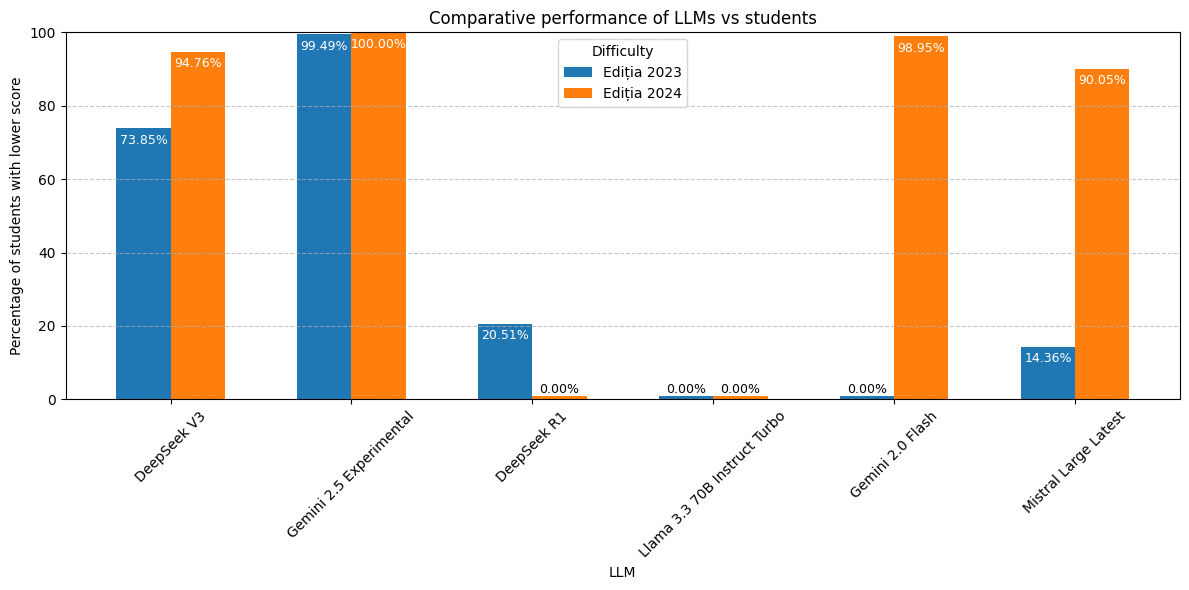

In [4]:
student_points = {
    "Ediția 2023": json.loads(open(internal_types.DATA_DIR / ".." / "other" / "2023_qualified_points.json").read()),
    "Ediția 2024": json.loads(open(internal_types.DATA_DIR / ".." / "other" / "2024_qualified_points.json").read()),
}

percentile_data = {
    model: dict()
    for model in MODELS
}

for model in MODELS:
    for edition in student_points.keys():
        # get the model's results.
        total_points = 0
        total_problems = 0
        for difficulty, is_correct in duckdb.sql(
            f"""
            SELECT difficulty, correct
            FROM solutions
            WHERE llm = '{model}' AND edition = '{edition}' and lang = 'ro'
            """
        ).fetchall():
            if is_correct:
                total_points += problem_difficulty_to_points(difficulty)
            total_problems += 1

        # We have 3 trials.
        if total_problems != 60:
            print(f"Warning: {model} did not solve all problems in {edition}.")
            continue

        # The average nr of points obtained by the model.
        total_points /= 3

        # See the ranking of the model compared to the students.
        nr_students = len(student_points[edition])
        nr_students_better = len([
            i for i in student_points[edition] if i > total_points
        ])
        ranking = 1 + nr_students_better

        # The ranking percentile.
        percentile = 100 * (nr_students_better / nr_students)

        print(f"{model} in {edition}: total points - {total_points:.2f} / ranking - {ranking}/{nr_students} / percentile - {percentile:.2f}%")
        # print(f"  - Total points: {total_points:.2f}")
        # print(f"  - Ranking: {ranking}/{nr_students} ({percentile:.2f}%)")
        # print(f"  - Percentile: Top {percentile:.2f}% of the students")

        percentile_data[model][edition] = 100 - percentile

# Plot the data
plt.figure(figsize=(12, 6))
bar_width = 0.3
index = np.arange(len(MODELS))

for i, edition in enumerate(student_points.keys()):
    percentile = [percentile_data[model][edition] for model in MODELS]
    bars = plt.bar(
        index + (i + 0.5) * bar_width,
        [max(i, 1) for i in percentile],
        bar_width,
        label=f"{edition}",
    )

    # Add values on top of the bars
    for bar, percentile in zip(bars, percentile):
        plt.text(
            bar.get_x() + bar_width / 2,
            (bar.get_height() - 0.05 if percentile < 10 else bar.get_height() - 5),
            f"{percentile:.2f}%",
            ha="center",
            va="bottom",
            fontsize=9,
            color=(
                "black" if percentile < 10 else "white"
            ),
        )

plt.xlabel("LLM")
plt.ylabel("Percentage of students with lower score")
plt.title("Comparative performance of LLMs vs students")
plt.xticks(index + bar_width, MODELS, rotation=45)
plt.ylim(0, 100)
plt.legend(title="Difficulty")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Computing the average accuracy by LLM

We are computing the average accuracy by LLM for each problem category (easy / medium / hard).

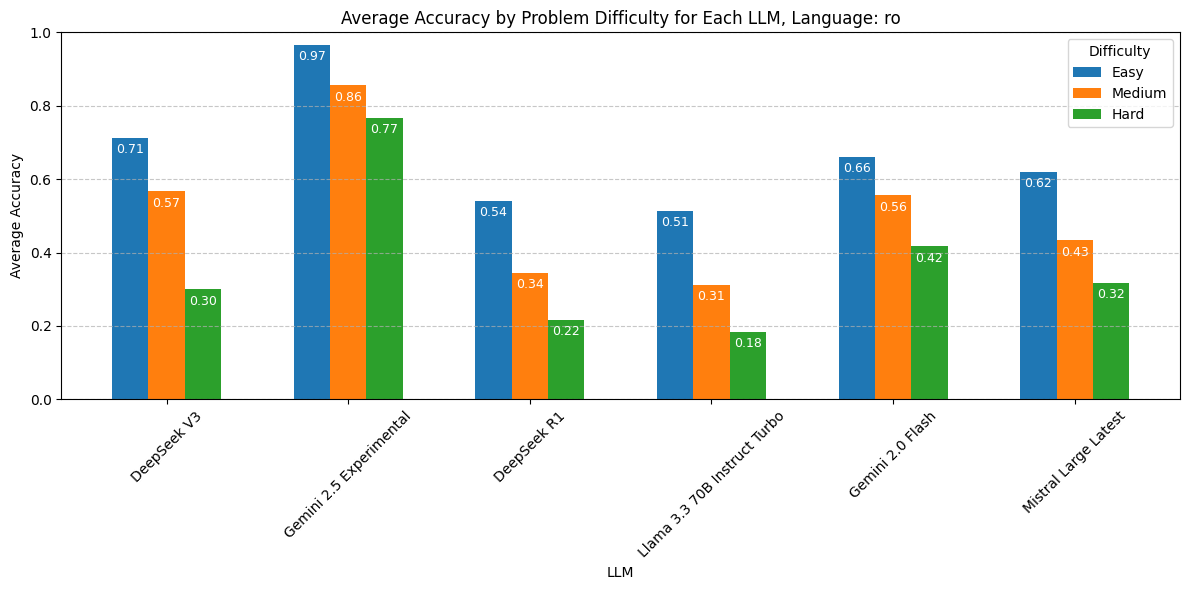

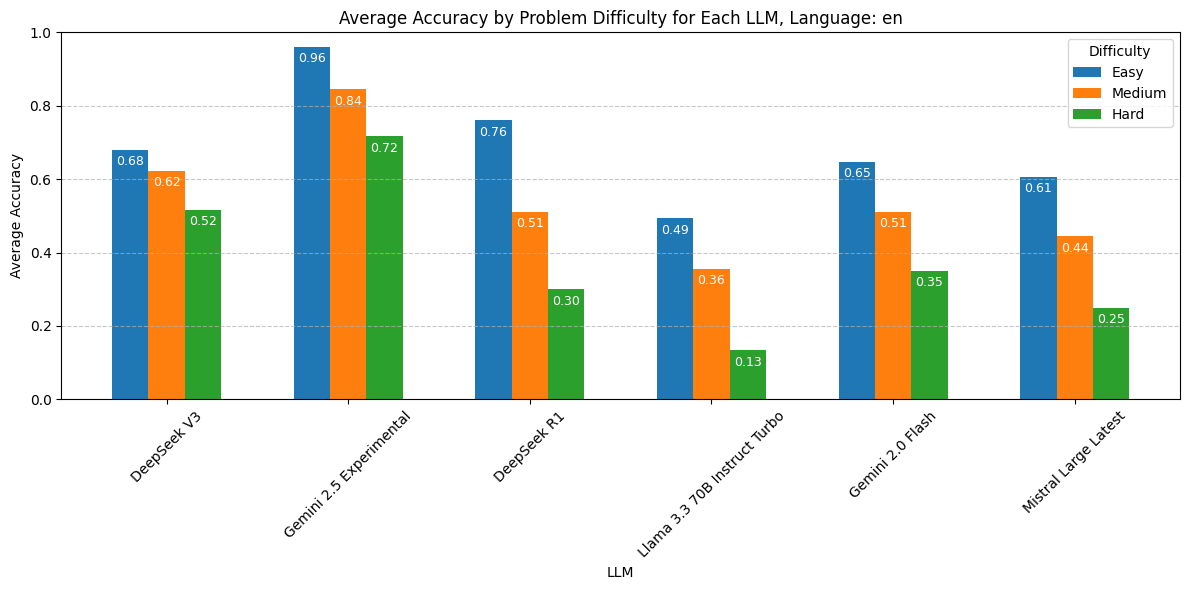

In [5]:
for lang in LANGS:
    # Extract data from DuckDB
    df = duckdb.sql(
    f"""
        SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
        FROM solutions
        WHERE lang = '{lang}'
        GROUP BY edition, problem_index, llm
    """).df()

    plot_data = { model: { "easy": [], "medium": [], "hard": [] } for model in MODELS }
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(row["accuracy"])

    # Plot the data


    # Calculate average accuracy for each difficulty level
    average_plot_data = {
        model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
        for model, data in plot_data.items()
    }

    # Plot the data
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    index = np.arange(len(MODELS))

    for i, difficulty in enumerate(["easy", "medium", "hard"]):
        accuracies = [average_plot_data[model][difficulty] for model in MODELS]
        bars = plt.bar(
            index + i * bar_width, accuracies, bar_width, label=f"{difficulty.capitalize()}"
        )

        # Add values on top of the bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - 0.05,
                f"{accuracy:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
            )

    plt.xlabel("LLM")
    plt.ylabel("Average Accuracy")
    plt.title("Average Accuracy by Problem Difficulty for Each LLM, Language: " + lang)
    plt.xticks(index + bar_width, MODELS, rotation=45)
    plt.ylim(0, 1)
    plt.legend(title="Difficulty")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

### Computing success rate when reasoning is asked vs not asked

We compute the average accuracy of the models when we ask the model for reasoning steps vs when we don't.

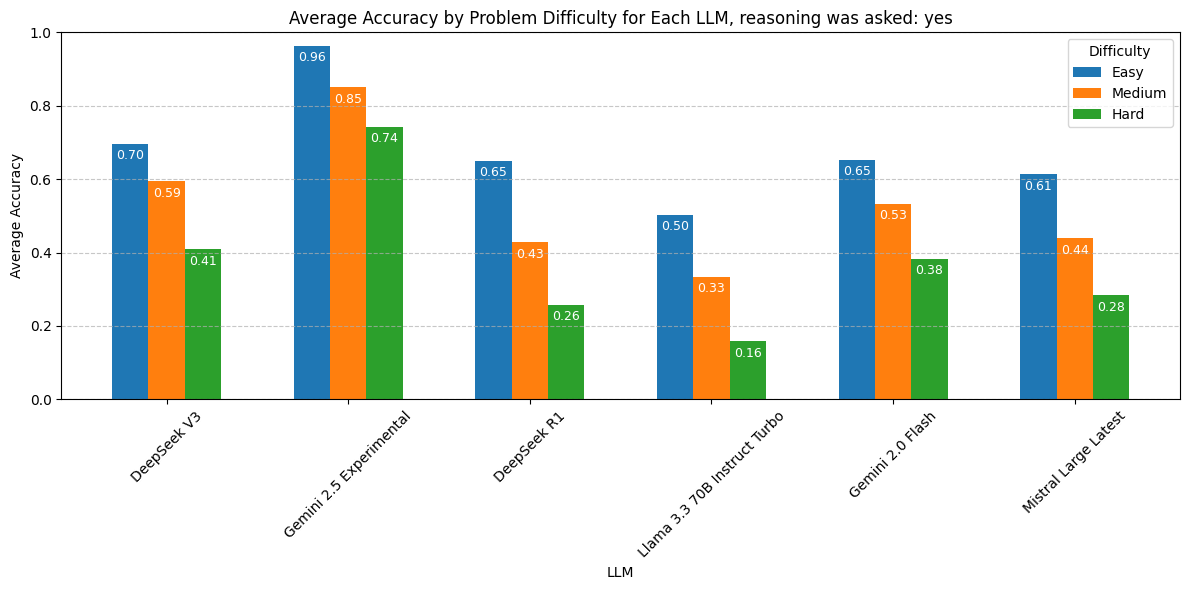

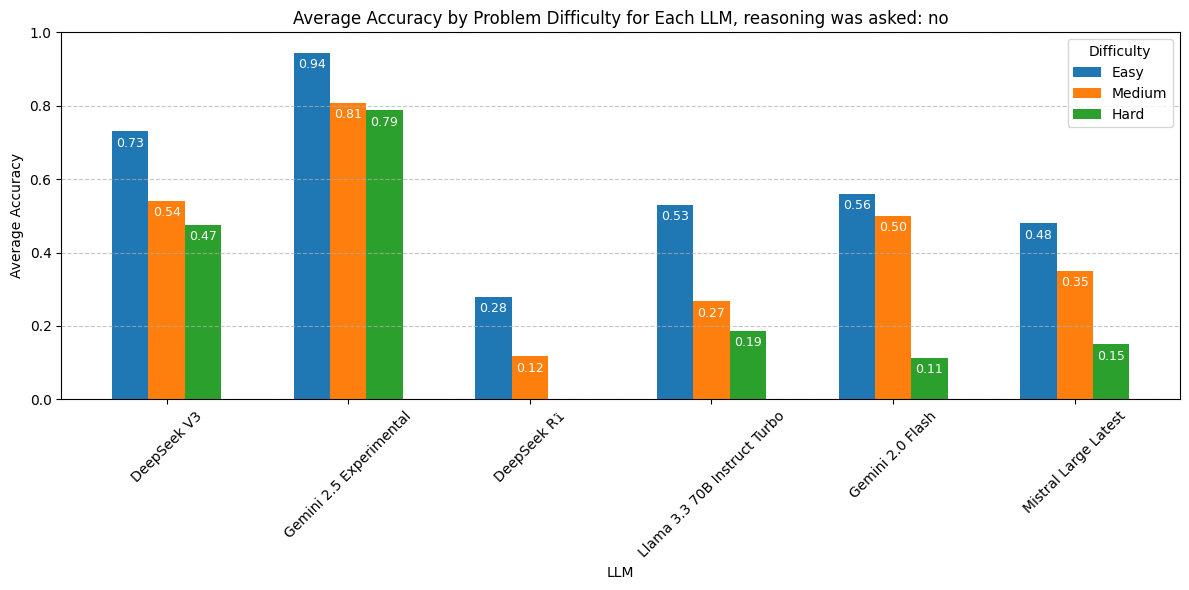

In [6]:
for sol_file in ["solutions", "solutions_no_reasoning"]:
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
        FROM {sol_file}
        GROUP BY edition, problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["accuracy"]
        )

    # Plot the data

    # Calculate average accuracy for each difficulty level
    average_plot_data = {
        model: {
            difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()
        }
        for model, data in plot_data.items()
    }

    # Plot the data
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    index = np.arange(len(MODELS))

    for i, difficulty in enumerate(["easy", "medium", "hard"]):
        accuracies = [average_plot_data[model][difficulty] for model in MODELS]
        bars = plt.bar(
            index + i * bar_width,
            accuracies,
            bar_width,
            label=f"{difficulty.capitalize()}",
        )

        # Add values on top of the bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - 0.05,
                f"{accuracy:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
            )

    plt.xlabel("LLM")
    plt.ylabel("Average Accuracy")
    plt.title("Average Accuracy by Problem Difficulty for Each LLM, reasoning was asked: " + ("no" if "reasoning" in sol_file else "yes"))
    plt.xticks(index + bar_width, MODELS, rotation=45)
    plt.ylim(0, 1)
    plt.legend(title="Difficulty")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

### Computing The number of Python solutions vs direct answers

In [7]:
Todo: check the plots, values to large. Also, maybe combine the plots.

SyntaxError: invalid syntax (3332977133.py, line 1)

{'DeepSeek V3': {'easy': np.int64(205), 'medium': np.int64(97), 'hard': np.int64(38)}, 'Gemini 2.5 Experimental': {'easy': np.int64(148), 'medium': np.int64(73), 'hard': np.int64(24)}, 'DeepSeek R1': {'easy': np.int64(298), 'medium': np.int64(169), 'hard': np.int64(108)}, 'Llama 3.3 70B Instruct Turbo': {'easy': np.int64(138), 'medium': np.int64(59), 'hard': np.int64(18)}, 'Gemini 2.0 Flash': {'easy': np.int64(239), 'medium': np.int64(96), 'hard': np.int64(51)}, 'Mistral Large Latest': {'easy': np.int64(215), 'medium': np.int64(91), 'hard': np.int64(37)}}


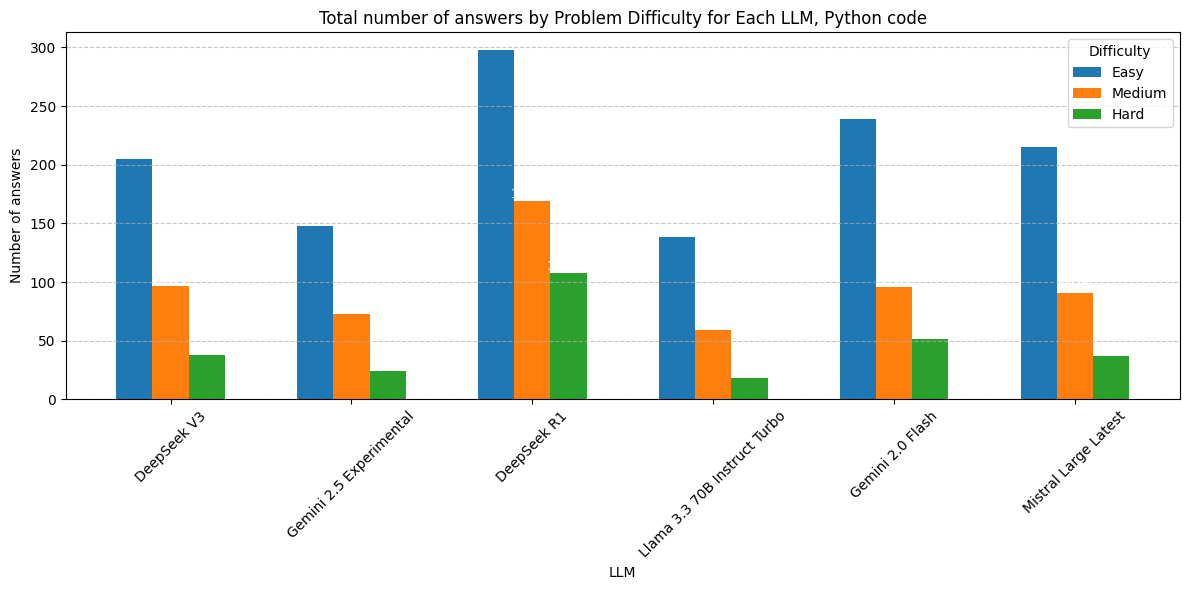

{'DeepSeek V3': {'easy': np.int64(95), 'medium': np.int64(83), 'hard': np.int64(82)}, 'Gemini 2.5 Experimental': {'easy': np.int64(152), 'medium': np.int64(107), 'hard': np.int64(96)}, 'DeepSeek R1': {'easy': np.int64(2), 'medium': np.int64(11), 'hard': np.int64(12)}, 'Llama 3.3 70B Instruct Turbo': {'easy': np.int64(162), 'medium': np.int64(121), 'hard': np.int64(102)}, 'Gemini 2.0 Flash': {'easy': np.int64(61), 'medium': np.int64(84), 'hard': np.int64(69)}, 'Mistral Large Latest': {'easy': np.int64(85), 'medium': np.int64(89), 'hard': np.int64(83)}}


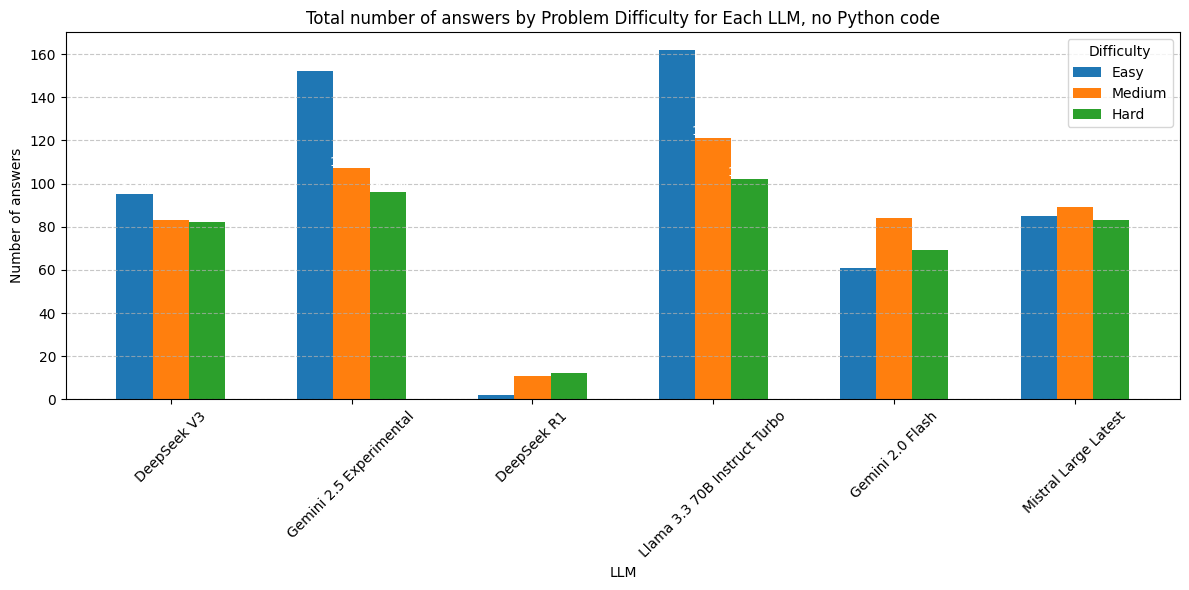

In [8]:
for use_python in [True, False]:
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT problem_index, llm, SUM(correct) as correct, COUNT(*) as total
        FROM solutions
        WHERE python_code is {"" if use_python else "not"} null
        GROUP BY problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["total"]
        )

    # Plot the data

    # Calculate total for each difficulty level
    total_plot_data = {
        model: {
            difficulty: np.sum(total) for difficulty, total in data.items()
        }
        for model, data in plot_data.items()
    }

    print(total_plot_data)

    # Plot the data
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    index = np.arange(len(MODELS))

    for i, difficulty in enumerate(["easy", "medium", "hard"]):
        total = [total_plot_data[model][difficulty] for model in MODELS]
        bars = plt.bar(
            index + i * bar_width,
            total,
            bar_width,
            label=f"{difficulty.capitalize()}",
        )

        # Add values on top of the bars
        for bar, accuracy in zip(bars, total):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - 0.05,
                f"{accuracy:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
            )

    plt.xlabel("LLM")
    plt.ylabel("Number of answers")
    plt.title(
        f"Total number of answers by Problem Difficulty for Each LLM, {'Python code' if use_python else 'no Python code'}"
    )
    plt.xticks(index + bar_width, MODELS, rotation=45)
    # plt.ylim(0, 1)
    plt.legend(title="Difficulty")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

### Computing Success rate when using Python

Writing python code is challenging, so seeing the success rate of the LLMs when using Python is interesting.

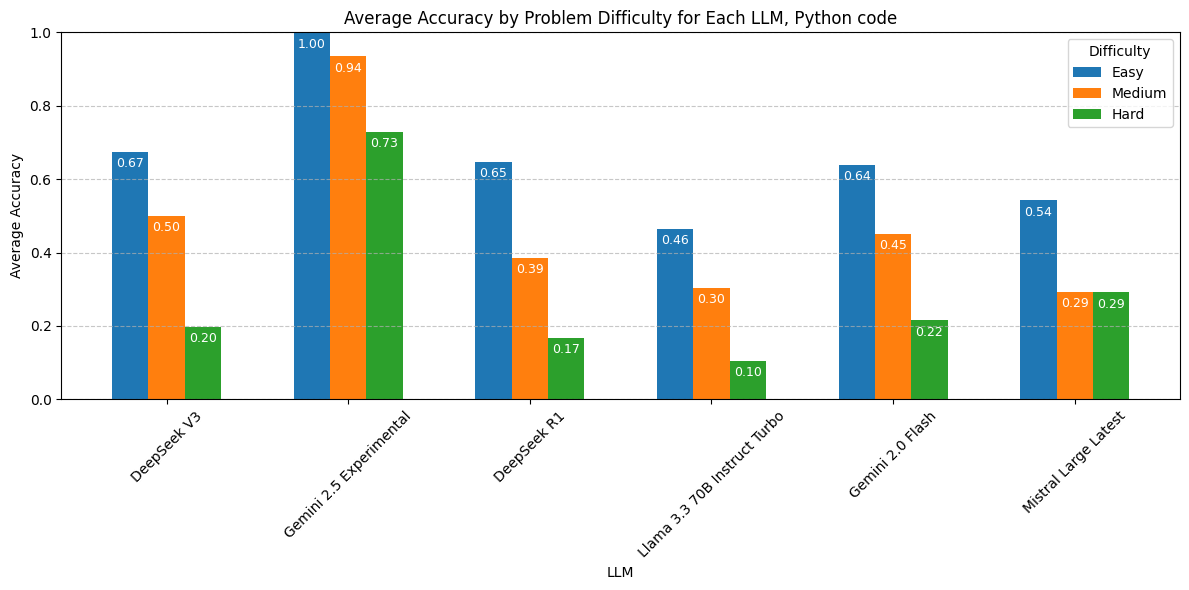

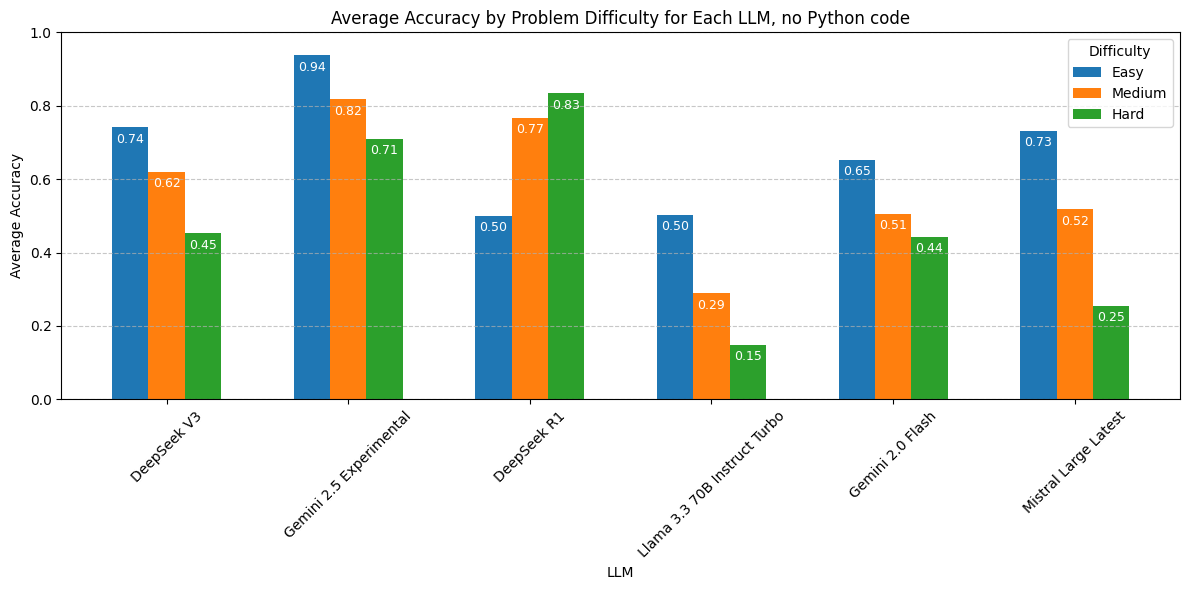

In [9]:
for use_python in [True, False]:
    # Extract data from DuckDB
    df = duckdb.sql(
        f"""
        SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy
        FROM solutions
        WHERE python_code is {"" if use_python else "not"} null
        GROUP BY edition, problem_index, llm
    """
    ).df()

    plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
    for _, row in df.iterrows():
        plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
            row["accuracy"]
        )

    # Plot the data

    # Calculate average accuracy for each difficulty level
    average_plot_data = {
        model: {
            difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()
        }
        for model, data in plot_data.items()
    }

    # Plot the data
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    index = np.arange(len(MODELS))

    for i, difficulty in enumerate(["easy", "medium", "hard"]):
        accuracies = [average_plot_data[model][difficulty] for model in MODELS]
        bars = plt.bar(
            index + i * bar_width,
            accuracies,
            bar_width,
            label=f"{difficulty.capitalize()}",
        )

        # Add values on top of the bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - 0.05,
                f"{accuracy:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                color="white",
            )

    plt.xlabel("LLM")
    plt.ylabel("Average Accuracy")
    plt.title(
        f"Average Accuracy by Problem Difficulty for Each LLM, {'Python code' if use_python else 'no Python code'}"
    )
    plt.xticks(index + bar_width, MODELS, rotation=45)
    plt.ylim(0, 1)
    plt.legend(title="Difficulty")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

## Data bellow is junk, please ignore.

In [10]:
%%sql_magic
DESC solutions

┌────────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│    column_name     │ column_type │  null   │   key   │ default │  extra  │
│      varchar       │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ edition            │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ problem_index      │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ title              │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ markdown_statement │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ answer_variants    │ VARCHAR[]   │ YES     │ NULL    │ NULL    │ NULL    │
│ correct_answer     │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ difficulty         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ image_path         │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ image_content      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │

In [ ]:
# Extract data from DuckDB
df = duckdb.sql(
    """
    SELECT edition, problem_index, llm, SUM(correct) as correct, AVG(CAST(correct as float)) as accuracy, COUNT(*) as total
    FROM data
    WHERE python_code IS NOT NULL
    GROUP BY edition, problem_index, llm
"""
).df()


plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
for _, row in df.iterrows():
    plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
        row["accuracy"]
    )

# Plot the data

# Calculate average accuracy for each difficulty level
average_plot_data = {
    model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
    for model, data in plot_data.items()
}

# Plot the data
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(MODELS))

for i, difficulty in enumerate(["easy", "medium", "hard"]):
    accuracies = [average_plot_data[model][difficulty] for model in MODELS]
    bars = plt.bar(
        index + i * bar_width, accuracies, bar_width, label=f"{difficulty.capitalize()}"
    )

    # Add values on top of the bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.05,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM (python code)")
plt.xticks(index + bar_width, MODELS, rotation=45)
plt.ylim(0, 1)
plt.legend(title="Difficulty")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

CatalogException: Catalog Error: Table with name data does not exist!
Did you mean "pg_database"?

In [ ]:
duckdb.sql("select * from data where python_code IS NOT NULL")

┌─────────────┬───────────────┬──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:

plot_data = {model: {"easy": [], "medium": [], "hard": []} for model in MODELS}
for _, row in df.iterrows():
    plot_data[row["llm"]][problem_index_to_difficulty(row["problem_index"])].append(
        row["accuracy"]
    )

# Plot the data

# Calculate average accuracy for each difficulty level
average_plot_data = {
    model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
    for model, data in plot_data.items()
}


# Calculate average accuracy for each difficulty level
average_plot_data = {
    model: {difficulty: np.mean(accuracies) for difficulty, accuracies in data.items()}
    for model, data in plot_data.items()
}

# Plot the data
plt.figure(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(MODELS))

for i, difficulty in enumerate(["easy", "medium", "hard"]):
    accuracies = [average_plot_data[model][difficulty] for model in MODELS]
    bars = plt.bar(
        index + i * bar_width, accuracies, bar_width, label=f"{difficulty.capitalize()}"
    )

    # Add values on top of the bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - 0.05,
            f"{accuracy:.2f}",
            ha="center",
            va="bottom",
            fontsize=9,
            color="white",
        )

plt.xlabel("LLM")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Problem Difficulty for Each LLM")
plt.xticks(index + bar_width, MODELS, rotation=45)
plt.ylim(0, 1)
plt.legend(title="Difficulty")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
for row in df.iterrows():
    print(row)

(0, edition          Ediția 2024
problem_index              0
llm                  mistral
correct                  0.0
accuracy                 0.0
Name: 0, dtype: object)
(1, edition                                Ediția 2024
problem_index                                    0
llm              Llama-3.3-70B-Instruct-Turbo-Free
correct                                        0.0
accuracy                                       0.0
Name: 1, dtype: object)
(2, edition          Ediția 2024
problem_index              5
llm                   gemini
correct                  3.0
accuracy                 1.0
Name: 2, dtype: object)
(3, edition          Ediția 2024
problem_index             12
llm              DeepSeek-V3
correct                  3.0
accuracy                 1.0
Name: 3, dtype: object)
(4, edition          Ediția 2024
problem_index             16
llm                  mistral
correct                  2.0
accuracy            0.666667
Name: 4, dtype: object)
(5, edition              

In [ ]:
df

,edition,problem_index,llm,correct,accuracy
0,Ediția 2024,0,mistral,0.0,0.000000
1,Ediția 2024,0,Llama-3.3-70B-Instruct-Turbo-Free,0.0,0.000000
2,Ediția 2024,5,gemini,3.0,1.000000
3,Ediția 2024,12,DeepSeek-V3,3.0,1.000000
4,Ediția 2024,16,mistral,2.0,0.666667
...,...,...,...,...,...
395,Ediția 2021,18,Llama-3.3-70B-Instruct-Turbo-Free,0.0,0.000000
396,Ediția 2024,19,mistral,3.0,1.000000
397,Ediția 2024,19,Llama-3.3-70B-Instruct-Turbo-Free,2.0,0.666667
398,Ediția 2021,0,gemini,2.0,0.666667


In [ ]:

# Convert to DataFrame
df = pd.DataFrame(
    data, columns=["edition", "llm", "problem_index", "answer", "correct_answer"]
)

# Calculate correctness
df["is_correct"] = df.apply(lambda row: row["answer"] == row["correct_answer"], axis=1)

# Group by LLM and calculate average, best, and worst accuracy
accuracy_by_llm = (
    df.groupby("llm")["is_correct"].agg(["mean", "max", "min"]).reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    accuracy_by_llm["llm"],
    accuracy_by_llm["mean"],
    color="skyblue",
    label="Average Accuracy",
)
plt.errorbar(
    accuracy_by_llm["llm"],
    accuracy_by_llm["mean"],
    yerr=[
        accuracy_by_llm["mean"] - accuracy_by_llm["min"],
        accuracy_by_llm["max"] - accuracy_by_llm["mean"],
    ],
    fmt="o",
    color="red",
    capsize=5,
    label="Best/Worst Performance",
)

plt.title("Average Accuracy by Model with Best and Worst Performances")
plt.xlabel("LLM")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.show()